In [ ]:
!pip3 install ipywidgets matplotlib opencv-python pandas torch torchvision tqdm

In [2]:
import cv2
import os.path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Data set and data loaders
The [Chinese MNIST dataset](https://www.kaggle.com/datasets/gpreda/chinese-mnist) is a small dataset of 15,000 images. Each image represents one of 15 simplified Chinese characters, written 10 times, by 100 volunteers. The characters represent the numbers one through nine, as well as one hundred, one thousand, ten thousand, and 100 million. 

In [3]:
CSV_PATH = './data/chinese_mnist.csv'
IMG_DIR = './data/data'

# Build and save image file names corresponding to each character record
csv = pd.read_csv(CSV_PATH)
csv['file'] = csv[['suite_id', 'sample_id', 'code']].apply(
    lambda x: f'input_{x["suite_id"]}_{x["sample_id"]}_{x["code"]}.jpg',
    axis=1
)
csv.head()

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


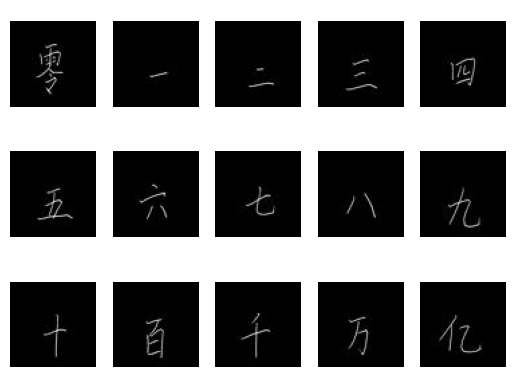

In [4]:

# Display an example of each possible character, all from the same participant
for i in range(15):
    image = cv2.imread(f'{IMG_DIR}/input_1_1_{i + 1}.jpg')
    plt.axis('off')
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)

plt.axis('off')
plt.show()

In [5]:
class ChineseMNISTDataset(Dataset):
    def __init__(self):
        self.labels = csv

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx: int):
        filename = self.labels.loc[idx, 'file']
        path = os.path.join(IMG_DIR, str(filename))
        image = cv2.imread(path).astype('float32')
        # (64, 64, 3) -> (3, 64, 64)
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image)
        
        # "code" is 1-indexed, but we need 0-indexed to correctly map to target classes
        label = self.labels.loc[idx, 'code'].astype(int) - 1
        return image, label
    
dataset = ChineseMNISTDataset()

In [6]:
# Examine a single image
image, label = dataset[0]
print(image.shape, label)

torch.Size([3, 64, 64]) 9


In [21]:
# Break dataset into separate groups for training and testing
train_set, val_set, test_set = random_split(dataset, [12000, 1500, 1500])

train_loader = DataLoader(dataset=train_set, batch_size=50, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=50)
test_loader = DataLoader(dataset=test_set, batch_size=50)

# Data loader length should be equal to its dataset length / batch size
len(train_loader), len(val_loader), len(test_loader)

(240, 30, 30)

# Model

In [8]:
INPUT_SIZE = 3 * 64 * 64
OUTPUT_SIZE = 15

class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Matrix1 = nn.Linear(INPUT_SIZE, 8384)
        self.Matrix2 = nn.Linear(8384, 4192)
        self.Matrix3 = nn.Linear(4192, 2096)
        self.Matrix4 = nn.Linear(2096, 1048)
        self.Matrix5 = nn.Linear(1048, OUTPUT_SIZE)

    def forward(self, x):
        out = x.view(-1, 64 * 64)
        out = self.Matrix1(out)
        out = self.Matrix2(F.relu(out))
        out = self.Matrix3(F.relu(out))
        out = self.Matrix4(F.relu(out))
        out = self.Matrix5(F.relu(out))
        return out

    
model = ImageClassifier()

# Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
epoch_losses = []

def train_model(epochs=5):
    model.train()
    num_batches = len(train_loader)
    
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()
            
            # Forward pass: compute predicted outputs
            output = model(data)
            
            # Compute the loss
            loss = criterion(output, target)
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Perform a single optimization step (parameter update)
            optimizer.step()
            
            running_loss += loss.item()
            epoch_losses.append((epoch + batch_idx / num_batches, loss.item()))

            if batch_idx % 50 == 49:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

train_model()

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/5], Step [50/250], Loss: 1.2225
Epoch [1/5], Step [100/250], Loss: 0.9931
Epoch [1/5], Step [150/250], Loss: 0.8461
Epoch [1/5], Step [200/250], Loss: 0.7145
Epoch [1/5], Step [250/250], Loss: 0.6559


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/5], Step [50/250], Loss: 0.4439
Epoch [2/5], Step [100/250], Loss: 0.4237
Epoch [2/5], Step [150/250], Loss: 0.3719
Epoch [2/5], Step [200/250], Loss: 0.3522
Epoch [2/5], Step [250/250], Loss: 0.3260


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/5], Step [50/250], Loss: 0.1704
Epoch [3/5], Step [100/250], Loss: 0.1567
Epoch [3/5], Step [150/250], Loss: 0.2422
Epoch [3/5], Step [200/250], Loss: 0.1478
Epoch [3/5], Step [250/250], Loss: 0.1618


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [4/5], Step [50/250], Loss: 0.0623
Epoch [4/5], Step [100/250], Loss: 0.0600
Epoch [4/5], Step [150/250], Loss: 0.0808
Epoch [4/5], Step [200/250], Loss: 0.0706
Epoch [4/5], Step [250/250], Loss: 0.0751


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [5/5], Step [50/250], Loss: 0.0302
Epoch [5/5], Step [100/250], Loss: 0.0336
Epoch [5/5], Step [150/250], Loss: 0.0289
Epoch [5/5], Step [200/250], Loss: 0.0272
Epoch [5/5], Step [250/250], Loss: 0.0355


In [ ]:
epochs, losses = zip(*epoch_losses)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [12]:
def evaluate_model():
    model.eval()
    
    correct = 0
    total = 0
    
    # Disable gradient computation
    with torch.no_grad():
        for data, target in tqdm(val_loader):
            # Forward pass: compute predicted outputs
            output = model(data)
            
            # Get the predicted class
            _, predicted = torch.max(output.data, 1)
            
            # Update the number of correct predictions and total samples
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

evaluate_model()

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 84.48%


84.48

# Testing

- [] Try a few images the trained model hasn't seen yet
- [] Upload/import a new hand-drawn image
- [] Return not just one, but a ranked group of 3-4 results
- [] How would we deploy this?